## Summing or Averaging Data with two types of missing values

Some datasets, for example radar data, have two types of missing values. In case of radar data, this could represent data outside the geographical range of the instrument and other missing values although inside the geographical measurment range. A typical example of such missing values would be measurment failure due to someone firing a gun at the radar - which happened twice in 2006 to a research radar based instrument in Darwin, Australia.

As the netCDF format doesn't support two kind of missing values, researchers often have to deal with this fundamentally different types of missing values that are represented by the same float number in the netCDF file.

This notebook demonstrates how such two kinds missing values, which are represented by the same float number in a netCDF file, can be treated when applying data reduction along the time axis. For example applying `sum` or `averages`.

The strategy here is to open the data using xarray, creating a numerical mask - representing one type of missing values - and defining a minimum threshold for good data (without too many occurrences of the other type of missing values) to be present within the reduction period.

Since the data will be big we are going to use `dask-distributed` to use distributed computing resources.

In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory
from getpass import getuser

from dask_jobqueue import SLURMCluster
import dask
import numpy as np
from dask.distributed import Client, progress
import xarray as xr

Create a distributed cluster first. We are going to use the compute node with 10 slurm jobs.

In [2]:
SCRATCH_DIR = Path('/scratch') / getuser()[0] / getuser()
dask_scratch_dir = TemporaryDirectory(dir=SCRATCH_DIR, prefix='MaskArray')
cluster = SLURMCluster(memory='60GiB',
                       cores=42,
                       project='ch1187',
                       walltime='08:00:00',
                       queue='compute',
                       name='ArrayMask',
                       local_directory=dask_scratch_dir.name,
                       job_extra=[f'-J ArrayMask', 
                                  f'-D {dask_scratch_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o'
                             ],
                   interface='ib0')
cluster.scale(jobs=10)
cluster

In [3]:
dask_client = Client(cluster)
dask_client

<Client: 'tcp://10.50.47.89:36769' processes=69 threads=414, memory=634.80 GB>

Open the precipitation dataset with xarray:

In [4]:
inp_dir = Path('/work/ch1187/regiklim-work/k204230/py-cmorlite/observations/grid/DWD/DWD/radolan/1hr/')
inp_files = sorted([str(f) for f in inp_dir.rglob('pr*.nc')])
dset = xr.open_mfdataset(inp_files, coords="minimal",
                                    data_vars="minimal",
                                    compat='override',
                                    combine='by_coords',
                                    parallel=True)
dset['lat'].data = np.flipud(dset['lat'].data)
dset

<xarray.Dataset>
Dimensions:  (time: 175320, x: 900, y: 1100)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01T01:00:00 ... 2021-01-01
    lon      (y, x) float32 dask.array<chunksize=(1100, 900), meta=np.ndarray>
    lat      (y, x) float32 dask.array<chunksize=(1100, 900), meta=np.ndarray>
  * x        (x) float32 -4.435e+05 -4.425e+05 ... 4.545e+05 4.555e+05
  * y        (y) float32 -3.66e+06 -3.661e+06 ... -4.758e+06 -4.759e+06
Data variables:
    pr       (time, y, x) float32 dask.array<chunksize=(743, 1100, 900), meta=np.ndarray>
Attributes: (12/21)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    history:                Thu Apr 29 12:24:48 2021: cdo -f nc4 splityearmon...
    Conventions:            CF-1.6
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...
    title:                  DWD observational output 
    institution_id:         DWD
    ...                     ...
    grid:                   1 x 1 km x km
    grid_label:             gn
    calendar:               gregorian
    cmor_version:           2.9.1
    initialization_method:  1
    physics_version:        1

Since this is radar data there are two "types" of missing data. 
* Points outside the measurment range
* Points within the measurment range but flagged as missing for various reasons.

Since we're interested in only missing values inside the measurment range we can create a mask and asign 1 for inside the measurment region while -1 is outside the region. Then we can assign data points outside the measurment region in the precipitation array as -1. -1 should be save as this is not really possible for precipitation.

So first create a mask. Since we do not have a mask we will have to create a mask. This can be done from a timestep that has no missing values within the geographical measurment range.

In [5]:
# Take the 1st teimstep and mask all nan values and assign them to -1
mask_float = np.ma.masked_invalid((dset['pr'].isel(time=0).values*0 + 1)).filled(-1)
# Create a dask array from this array, this is for distributed processing
mask_da = dask.array.from_array(mask_float, name='mask')
# Create a xarray DataArray from the dask array
mask = xr.DataArray(mask_da, name='mask', dims=dset['pr'].isel(time=0).dims, coords=dset['pr'].isel(time=0).coords)
mask

<xarray.DataArray 'mask' (y: 1100, x: 900)>
dask.array<mask, shape=(1100, 900), dtype=float32, chunksize=(1100, 900), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2001-01-01T01:00:00
    lon      (y, x) float32 dask.array<chunksize=(1100, 900), meta=np.ndarray>
    lat      (y, x) float32 dask.array<chunksize=(1100, 900), meta=np.ndarray>
  * x        (x) float32 -4.435e+05 -4.425e+05 ... 4.545e+05 4.555e+05
  * y        (y) float32 -3.66e+06 -3.661e+06 ... -4.758e+06 -4.759e+06

Smoke test: Plot data with both missing values outside and inside the measurment range, using the mask to set values outside the measurment range to -1. This dataset has missing vlaues in timestep number 179 (for example). Let's plot it. To create some contrast we set the area outside the geogrpahic measurement range to -100.

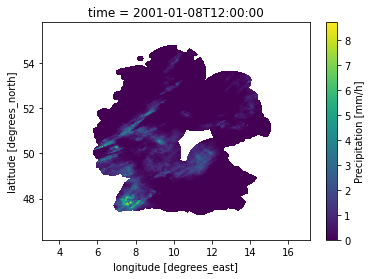

In [6]:
pr_missing = dset['pr'].isel(time=slice(0, 191))
pr_missing.isel(time=179).plot.pcolormesh('lon', 'lat')

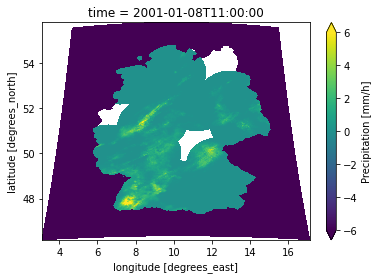

In [7]:
pr_missing.where(mask==1, -100).isel(time=-13).plot.pcolormesh('lon', 'lat', vmin=-6, vmax=6)

This was fast, because nothing has been calculated. xarray works with dask under the hood and creates so called futures. That is a chain of tasks that will be executed in the future. Dask creates a task graph and tries to optimise the task. We can instruct xarray to start the computation by either calling the `compute` method (computation is done locally) or the `persist` method where the computation is done on a distributed cluster. Since we have 10 slurm nodes with more than half a Terabyte of distirbuted memory we trigger the computation there.

In [8]:
pr_missing = pr_missing.where(mask==1, -1).persist()
# Inspect the progress of the computation on the cluster
progress(pr_missing)

VBox()

We could now just create daily sums of rainfall. But we want to check if there are consecutive hours with missing values first. We can do this by setting everything that has numerical data >= 0 to 1. Or simply by mulitplying the dataset with 0 (everything that is not nan, will become 0) and adding 1. The `fillna` method helps us to set the nan values to 0.

In [9]:
# Now let's create daily rainfall sums
good_data = (pr_missing * 0 + 1).fillna(0) #All numerical values are set to 1, nan values to 0
good_data.name = 'count'

Now count the daily *good* measurments at each grid point

In [10]:
good_data_daily = good_data.resample(time='1d').sum(dim='time').persist()
progress(good_data_daily)

VBox()

In [11]:
good_data_daily

<xarray.DataArray 'count' (time: 8, y: 1100, x: 900)>
dask.array<stack, shape=(8, 1100, 900), dtype=float32, chunksize=(1, 1100, 900), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-01-08
    lon      (y, x) float32 dask.array<chunksize=(1100, 900), meta=np.ndarray>
    lat      (y, x) float32 dask.array<chunksize=(1100, 900), meta=np.ndarray>
  * x        (x) float32 -4.435e+05 -4.425e+05 ... 4.545e+05 4.555e+05
  * y        (y) float32 -3.66e+06 -3.661e+06 ... -4.758e+06 -4.759e+06

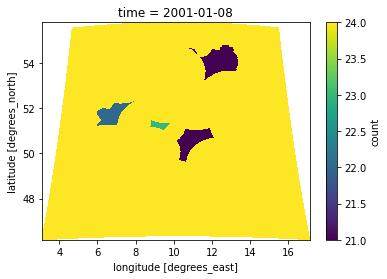

In [12]:
good_data_daily.isel(time=-1).plot.pcolormesh('lon', 'lat')

In [13]:
# Create a mask which is one where we have more than 21 non-misisng values per day and nan otherwise
good_flag = xr.where(good_data_daily > 21, 1, np.nan).persist()

In [15]:
# Create daily sums of precipiation and apply the good_flag data
pr_daily = (pr_missing.resample(time='1d').sum(dim='time') * good_flag)

Now we reapply the mask for the regions outside the geographical measurment range. We have defined values out of sight of the radars as -1. Hence the daily sums less than 0. These negative regions can easily be set to 0:

In [16]:
pr_daily_mask = pr_daily.where(pr_daily>=0, drop=True).persist()
progress(pr_daily_mask)

VBox()

Finally inspect the outcome

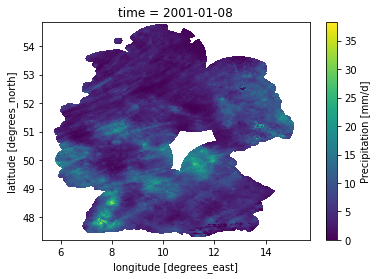

In [19]:
pr_daily_mask.attrs = dict(long_name='Precipitation', units='mm/d')
pr_daily_mask.isel(time=-1).plot.pcolormesh('lon', 'lat')